In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [5]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

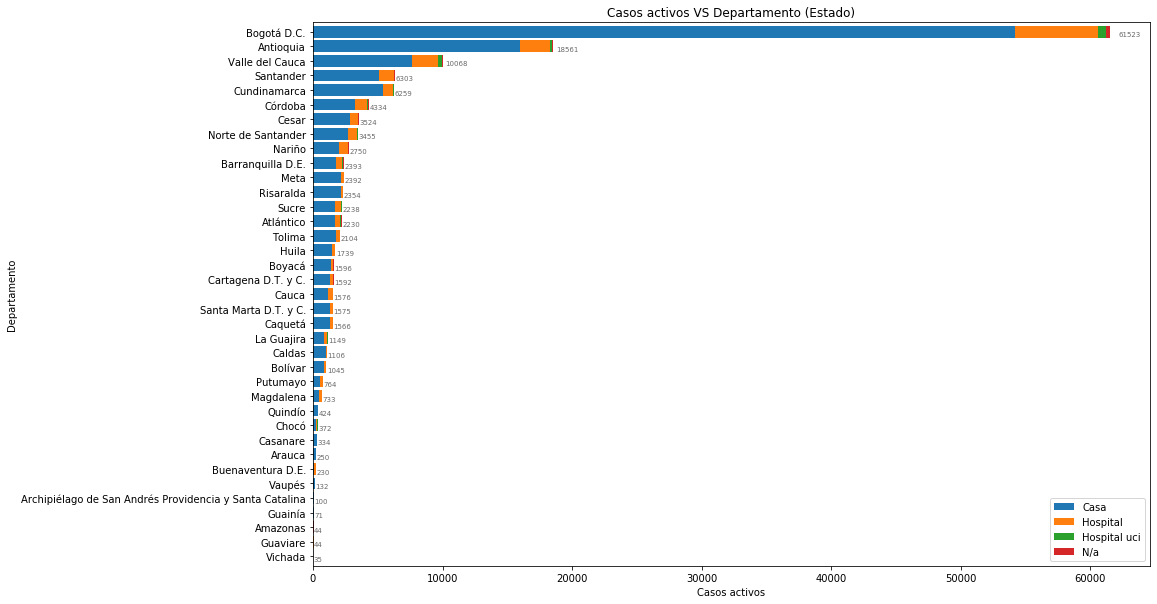

In [47]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [12]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         54183.0    6442.0   
Antioquia                                           16011.0    2260.0   
Valle del Cauca                                      7659.0    2016.0   
Santander                                            5084.0    1141.0   
Cundinamarca                                         5412.0     794.0   
Córdoba                                              3282.0     897.0   
Cesar                                                2863.0     600.0   
Norte de Santander                                   2735.0     629.0   
Nariño                                               2033.0     644.0   
Barranquilla D.E.                                    1741.0     502.0   
Meta                                                 2148.0     216.0   
Risaralda                                            2150.0     185.0   
Sucre                                                1687.0     505.0   
Atlántico                                            1704.0     373.0   
Tolima                                               1810.0     247.0   
Huila                                                1444.0     276.0   
Boyacá                                               1418.0     152.0   
Cartagena D.T. y C.                                  1323.0     194.0   
Cauca                                                1155.0     354.0   
Santa Marta D.T. y C.                                1289.0     254.0   
Caquetá                                              1292.0     252.0   
La Guajira                                            880.0     234.0   
Caldas                                                970.0     113.0   
Bolívar                                               867.0     134.0   
Putumayo                                              555.0     196.0   
Magdalena                                             479.0     193.0   
Quindío                                               391.0      30.0   
Chocó                                                 198.0     144.0   
Casanare                                              284.0      46.0   
Arauca                                                220.0      26.0   
Buenaventura D.E.                                     107.0      99.0   
Vaupés                                                126.0       6.0   
Archipiélago de San Andrés Providencia y Santa ...     90.0       9.0   
Guainía                                                70.0       1.0   
Amazonas                                               32.0       7.0   
Guaviare                                               40.0       3.0   
Vichada                                                33.0       2.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                594.0  304.0   
Antioquia                                                  192.0   98.0   
Valle del Cauca                                            289.0  104.0   
Santander                                                   55.0   23.0   
Cundinamarca                                                24.0   29.0   
Córdoba                                                     77.0   78.0   
Cesar                                                       46.0   15.0   
Norte de Santander                                          76.0   15.0   
Nariño                                                      45.0   28.0   
Barranquilla D.E.                                           51.0   99.0   
Meta                                                        12.0   16.0   
Risaralda                                                   11.0    8.0   
Sucre                                                       23.0   23.0   
Atlántico                  

### - Recuperados VS Departamento

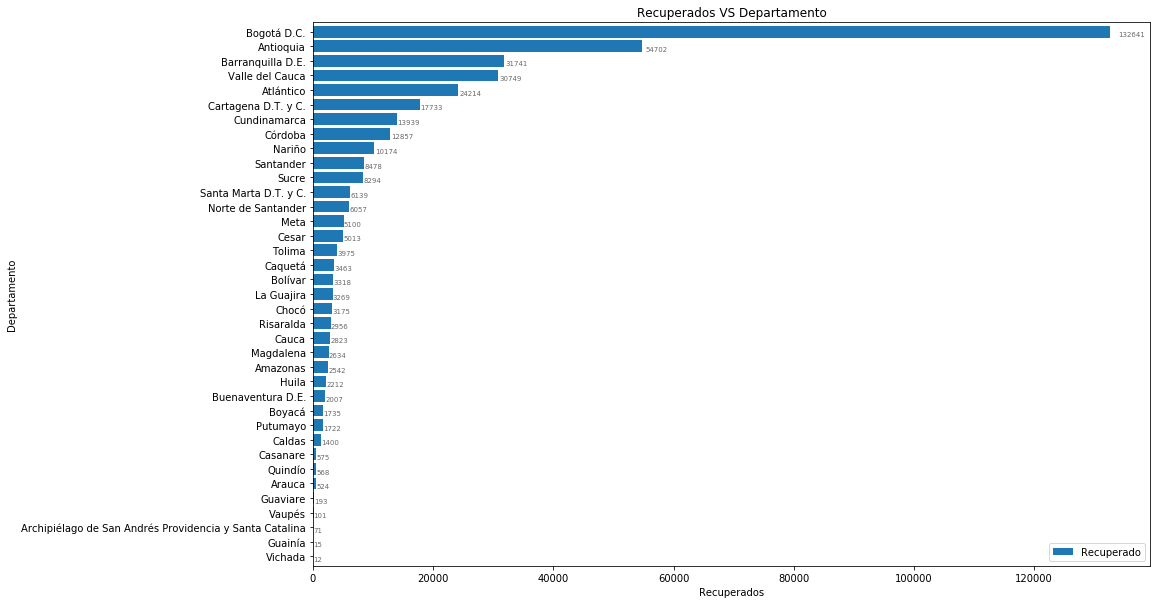

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, False, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Recuperados VS Departamento'))
ax.set_xlabel('Recuperados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                              Recuperado     Total
Departamento                                                            
Bogotá D.C.                                           132641.0  132641.0
Antioquia                                              54702.0   54702.0
Barranquilla D.E.                                      31741.0   31741.0
Valle del Cauca                                        30749.0   30749.0
Atlántico                                              24214.0   24214.0
Cartagena D.T. y C.                                    17733.0   17733.0
Cundinamarca                                           13939.0   13939.0
Córdoba                                                12857.0   12857.0
Nariño                                                 10174.0   10174.0
Santander                                               8478.0    8478.0
Sucre                                                   8294.0    8294.0
Santa Marta D.T. y C.                                   6139.0    6139.0
Norte de Santander                                      6057.0    6057.0
Meta                                                    5100.0    5100.0
Cesar                                                   5013.0    5013.0
Tolima                                                  3975.0    3975.0
Caquetá                                                 3463.0    3463.0
Bolívar                                                 3318.0    3318.0
La Guajira                                              3269.0    3269.0
Chocó                                                   3175.0    3175.0
Risaralda                                               2956.0    2956.0
Cauca                                                   2823.0    2823.0
Magdalena                                               2634.0    2634.0
Amazonas                                                2542.0    2542.0
Huila                                                   2212.0    2212.0
Buenaventura D.E.                                       2007.0    2007.0
Boyacá                                                  1735.0    1735.0
Putumayo                                                1722.0    1722.0
Caldas                                                  1400.0    1400.0
Casanare                                                 575.0     575.0
Quindío                                                  568.0     568.0
Arauca                                                   524.0     524.0
Guaviare                                                 193.0     193.0
Vaupés                                                   101.0     101.0
Archipiélago de San Andrés Providencia y Santa ...        71.0      71.0
Guainía                                                   15.0      15.0
Vichada                                                   12.0      12.0

### - Fallecidos VS Departamento

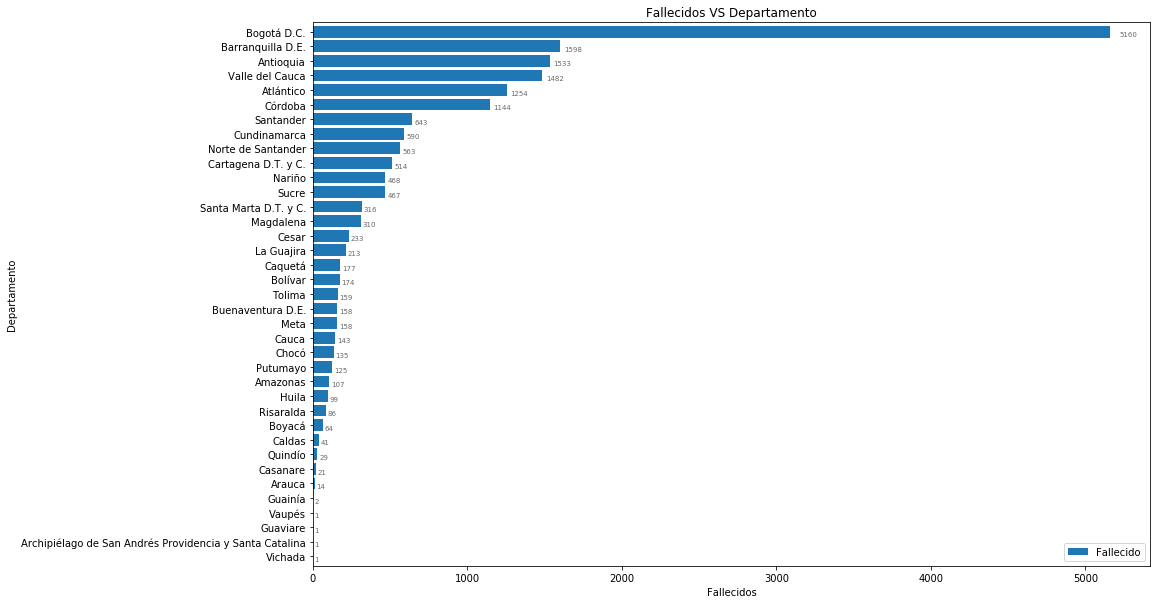

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Fallecidos VS Departamento'))
ax.set_xlabel('Fallecidos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                              Fallecido   Total
Departamento                                                         
Bogotá D.C.                                            5160.0  5160.0
Barranquilla D.E.                                      1598.0  1598.0
Antioquia                                              1533.0  1533.0
Valle del Cauca                                        1482.0  1482.0
Atlántico                                              1254.0  1254.0
Córdoba                                                1144.0  1144.0
Santander                                               643.0   643.0
Cundinamarca                                            590.0   590.0
Norte de Santander                                      563.0   563.0
Cartagena D.T. y C.                                     514.0   514.0
Nariño                                                  468.0   468.0
Sucre                                                   467.0   467.0
Santa Marta D.T. y C.                                   316.0   316.0
Magdalena                                               310.0   310.0
Cesar                                                   233.0   233.0
La Guajira                                              213.0   213.0
Caquetá                                                 177.0   177.0
Bolívar                                                 174.0   174.0
Tolima                                                  159.0   159.0
Buenaventura D.E.                                       158.0   158.0
Meta                                                    158.0   158.0
Cauca                                                   143.0   143.0
Chocó                                                   135.0   135.0
Putumayo                                                125.0   125.0
Amazonas                                                107.0   107.0
Huila                                                    99.0    99.0
Risaralda                                                86.0    86.0
Boyacá                                                   64.0    64.0
Caldas                                                   41.0    41.0
Quindío                                                  29.0    29.0
Casanare                                                 21.0    21.0
Arauca                                                   14.0    14.0
Guainía                                                   2.0     2.0
Guaviare                                                  1.0     1.0
Archipiélago de San Andrés Providencia y Santa ...        1.0     1.0
Vaupés                                                    1.0     1.0
Vichada                                                   1.0     1.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

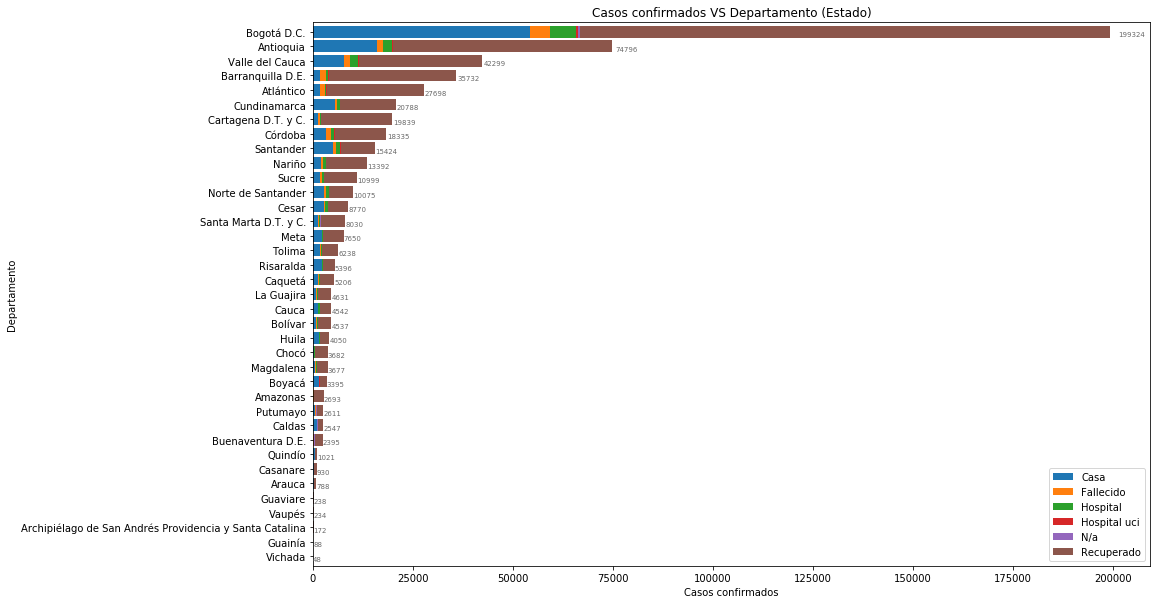

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         54183.0     5160.0   
Antioquia                                           16011.0     1533.0   
Valle del Cauca                                      7659.0     1482.0   
Barranquilla D.E.                                    1741.0     1598.0   
Atlántico                                            1704.0     1254.0   
Cundinamarca                                         5412.0      590.0   
Cartagena D.T. y C.                                  1323.0      514.0   
Córdoba                                              3282.0     1144.0   
Santander                                            5084.0      643.0   
Nariño                                               2033.0      468.0   
Sucre                                                1687.0      467.0   
Norte de Santander                                   2735.0      563.0   
Cesar                                                2863.0      233.0   
Santa Marta D.T. y C.                                1289.0      316.0   
Meta                                                 2148.0      158.0   
Tolima                                               1810.0      159.0   
Risaralda                                            2150.0       86.0   
Caquetá                                              1292.0      177.0   
La Guajira                                            880.0      213.0   
Cauca                                                1155.0      143.0   
Bolívar                                               867.0      174.0   
Huila                                                1444.0       99.0   
Chocó                                                 198.0      135.0   
Magdalena                                             479.0      310.0   
Boyacá                                               1418.0       64.0   
Amazonas                                               32.0      107.0   
Putumayo                                              555.0      125.0   
Caldas                                                970.0       41.0   
Buenaventura D.E.                                     107.0      158.0   
Quindío                                               391.0       29.0   
Casanare                                              284.0       21.0   
Arauca                                                220.0       14.0   
Guaviare                                               40.0        1.0   
Vaupés                                                126.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     90.0        1.0   
Guainía                                                70.0        2.0   
Vichada                                                33.0        1.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6442.0         594.0   
Antioquia                                             2260.0         192.0   
Valle del Cauca                                       2016.0         289.0   
Barranquilla D.E.                                      502.0          51.0   
Atlántico                                              373.0          62.0   
Cundinamarca                                           794.0          24.0   
Cartagena D.T. y C.                                    194.0          41.0   
Córdoba                                                897.0          77.0   
Santander                                             1141.0          55.0   
Nariño                                                 644.0          45.0   
Sucre                                                  505.0          23.0   
Norte de Santander                                     629.0          76.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

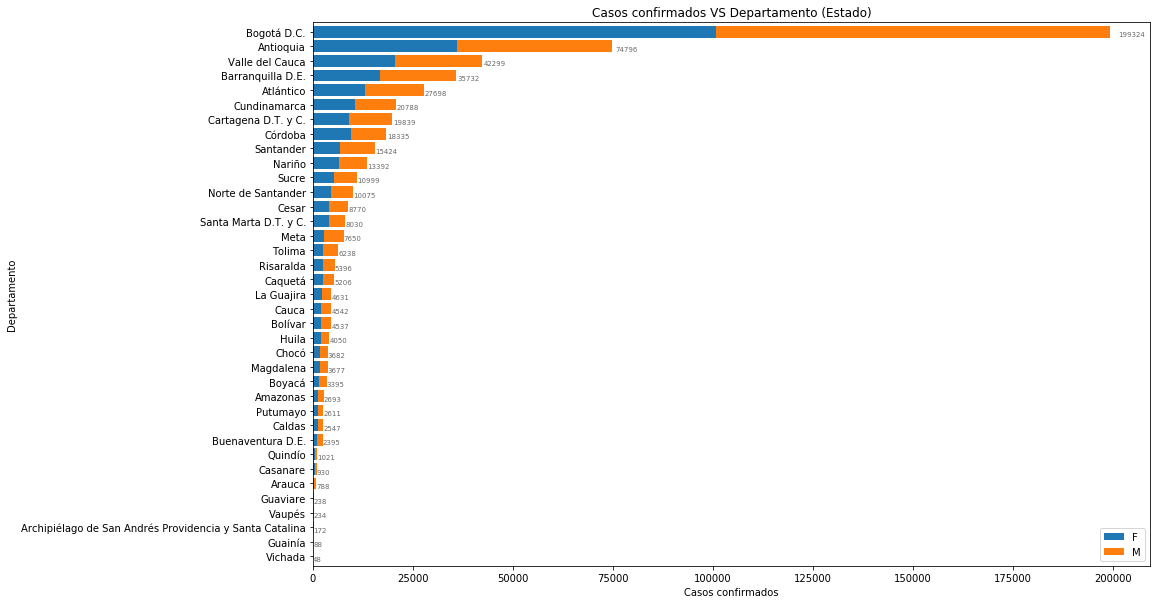

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F      M   Total
Departamento                                                             
Bogotá D.C.                                         100869  98455  199324
Antioquia                                            35940  38856   74796
Valle del Cauca                                      20468  21831   42299
Barranquilla D.E.                                    16830  18902   35732
Atlántico                                            13132  14566   27698
Cundinamarca                                         10535  10253   20788
Cartagena D.T. y C.                                   9116  10723   19839
Córdoba                                               9395   8940   18335
Santander                                             6683   8741   15424
Nariño                                                6414   6978   13392
Sucre                                                 5321   5678   10999
Norte de Santander                                    4611   5464   10075
Cesar                                                 4014   4756    8770
Santa Marta D.T. y C.                                 4043   3987    8030
Meta                                                  2843   4807    7650
Tolima                                                2425   3813    6238
Risaralda                                             2631   2765    5396
Caquetá                                               2573   2633    5206
La Guajira                                            2341   2290    4631
Cauca                                                 2116   2426    4542
Bolívar                                               2105   2432    4537
Huila                                                 2000   2050    4050
Chocó                                                 1744   1938    3682
Magdalena                                             1861   1816    3677
Boyacá                                                1565   1830    3395
Amazonas                                              1164   1529    2693
Putumayo                                              1173   1438    2611
Caldas                                                1214   1333    2547
Buenaventura D.E.                                      894   1501    2395
Quindío                                                510    511    1021
Casanare                                               388    542     930
Arauca                                                 250    538     788
Guaviare                                                35    203     238
Vaupés                                                 106    128     234
Archipiélago de San Andrés Providencia y Santa ...      97     75     172
Guainía                                                 36     52      88
Vichada                                                 13     35      48

### - Dataset COVID-19 (Colombia)

In [21]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
572306               2020-08-26           2020-08-21            2020-08-10   
572307               2020-08-26           2020-08-20            2020-08-09   
572308               2020-08-26           2020-08-19            2020-08-08   
572309               2020-08-26           2020-08-22            2020-08-11   
572310               2020-08-26           2020-08-21            2020-08-10   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
572306             2020-08-06 00:00:00                   NaT   
572307             2020-08-05 00:00:00                   NaT   
572308             2020-08-04 00:00:00                   NaT   
572309             2020-08-07 00:00:00                   NaT   
572310             2020-08-06 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
572306                    NaT             Medellín        Antioquia      Leve   
572307                    NaT             Medellín        Antioquia      Leve   
572308                    NaT             Medellín        Antioquia      Leve   
572309                    NaT             Medellín        Antioquia      Leve   
572310                    NaT             Medellín        Antioquia      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
572306            Casa  ...                40 - 50    M               NaN   
572307            Casa  ...                40 - 50    M               NaN   
572308            Casa  ...                40 - 50    M               NaN   
572309            Casa  ...                30 - 40    M               NaN   
572310            Casa  ...                50 - 60    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

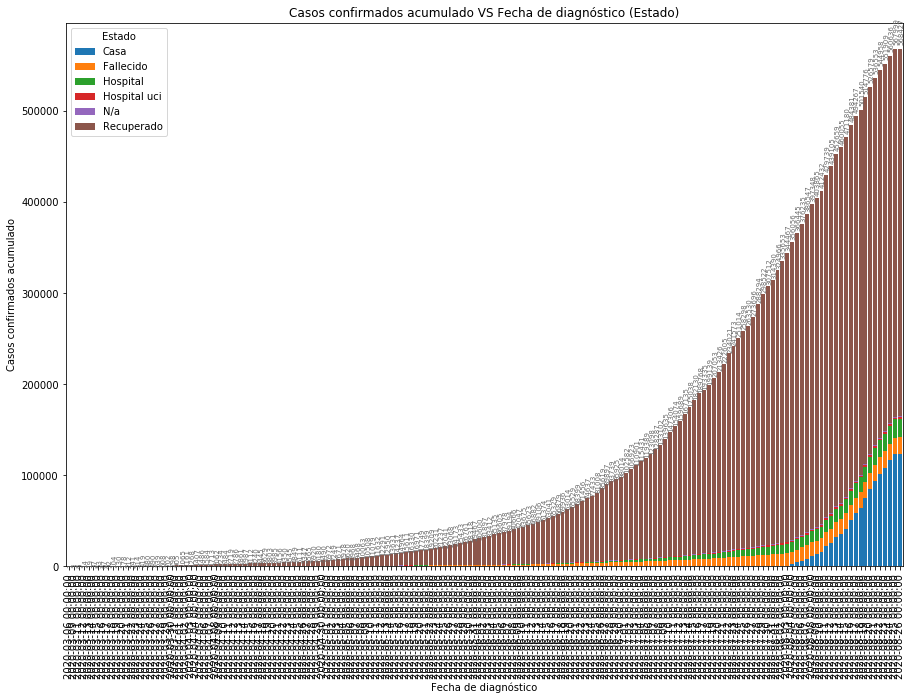

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-26            123760.0    17980.0   20090.0        1839.0  1148.0   
2020-08-25            123398.0    17980.0   20024.0        1839.0  1148.0   
2020-08-24            116484.0    17971.0   19584.0        1839.0  1148.0   
2020-08-23            108288.0    17896.0   19137.0        1835.0  1144.0   
2020-08-22            101716.0    17834.0   18822.0        1835.0  1142.0   
2020-08-21             93920.0    17718.0   18350.0        1831.0  1137.0   
2020-08-20             84983.0    17591.0   17817.0        1821.0  1126.0   
2020-08-19             74987.0    17352.0   17070.0        1789.0  1116.0   
2020-08-18             63980.0    17167.0   16488.0        1782.0  1104.0   
2020-08-17             58169.0    16997.0   16085.0        1781.0  1090.0   
2020-08-16             50435.0    16878.0   15733.0        1778.0  1084.0   
2020-08-15             41463.0    16654.0   15262.0        1777.0  1077.0   
2020-08-14             35425.0    16424.0   14780.0        1765.0  1070.0   
2020-08-13             32209.0    16224.0   14451.0        1756.0  1062.0   
2020-08-12             25417.0    15972.0   13935.0        1737.0  1050.0   
2020-08-11             22131.0    15677.0   13439.0        1716.0  1041.0   
2020-08-10             15328.0    15320.0   12755.0        1659.0  1025.0   
2020-08-09             13085.0    15125.0   12400.0        1642.0  1008.0   
2020-08-08             11269.0    14919.0   12077.0        1621.0  1004.0   
2020-08-07              8318.0    14634.0   11766.0        1587.0   991.0   
2020-08-06              6266.0    14376.0   11421.0        1540.0   974.0   
2020-08-05              4298.0    14112.0   11111.0        1494.0   954.0   
2020-08-04              2214.0    13845.0   10750.0        1448.0   933.0   
2020-08-03               796.0    13541.0   10416.0        1403.0   918.0   
2020-08-02               591.0    13227.0   10020.0        1363.0   901.0   
2020-08-01               512.0    12883.0    9604.0        1321.0   887.0   
2020-07-31               485.0    12553.0    9139.0        1286.0   867.0   
2020-07-30               435.0    12328.0    8874.0        1266.0   852.0   
2020-07-29               370.0    12050.0    8587.0        1222.0   832.0   
2020-07-28               328.0    11770.0    8246.0        1176.0   811.0   
2020-07-27               263.0    11235.0    7718.0        1118.0   777.0   
2020-07-26               228.0    10922.0    7407.0        1081.0   757.0   
2020-07-25               220.0    10686.0    7212.0        1055.0   746.0   
2020-07-24               190.0    10388.0    6893.0        1019.0   732.0   
2020-07-23               158.0    10094.0    6583.0         984.0   711.0   
2020-07-22               143.0     9727.0    6236.0         944.0   683.0   
2020-07-21               103.0     9289.0    5809.0         890.0   657.0   
2020-07-20                79.0     8946.0    5523.0         839.0   643.0   
2020-07-19                77.0     8677.0    5203.0         807.0   631.0   
2020-07-18                75.0     8402.0    4938.0         781.0   614.0   
2020-07-17                74.0     8165.0    4759.0         752.0   592.0   
2020-07-16                73.0     7991.0    4651.0         738.0   583.0   
2020-07-15                45.0     7710.0    4385.0         700.0   563.0   
2020-07-14                13.0     7416.0    4163.0         666.0   552.0   
2020-07-13                13.0     7132.0    3930.0         637.0   527.0   
2020-07-12                12.0     6866.0    3680.0         604.0   506.0   
2020-07-11                11.0     6654.0    3525.0         575.0   492.0   
2020-07-10                10.0     6395.0    3313.0         556.0   465.0   
2020-07-09                10.0     6176.0    3114.0         527.0   447.0   
2020-07-08                10.0     5883.0    2864.0         484.0   437.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

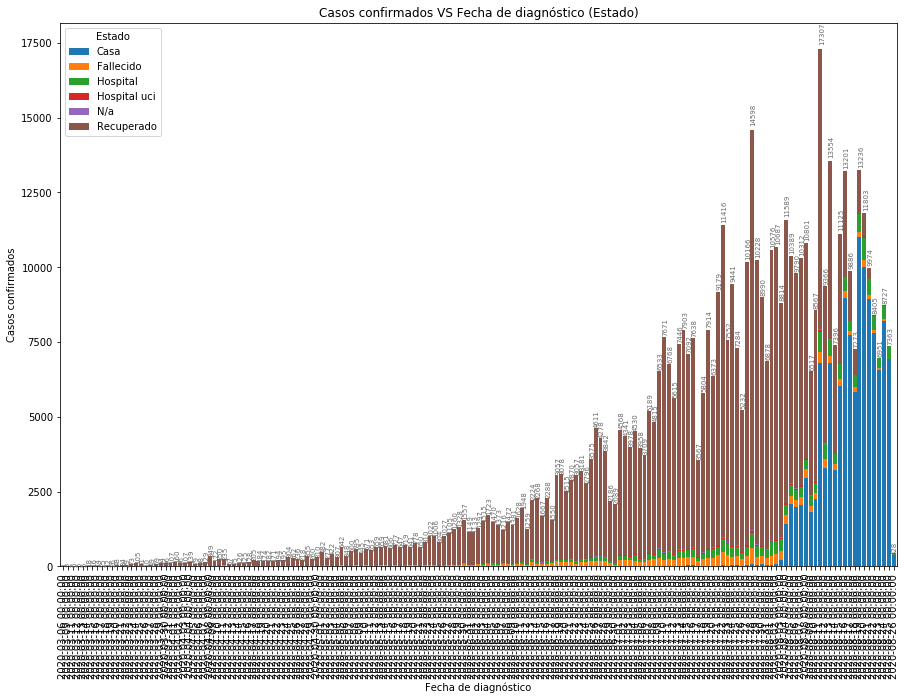

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-08-26              362.0        0.0      66.0           0.0   0.0   
2020-08-25             6914.0        9.0     440.0           0.0   0.0   
2020-08-24             8196.0       75.0     447.0           4.0   4.0   
2020-08-23             6572.0       62.0     315.0           0.0   2.0   
2020-08-22             7796.0      116.0     472.0           4.0   5.0   
2020-08-21             8937.0      127.0     533.0          10.0  11.0   
2020-08-20             9996.0      239.0     747.0          32.0  10.0   
2020-08-19            11007.0      185.0     582.0           7.0  12.0   
2020-08-18             5811.0      170.0     403.0           1.0  14.0   
2020-08-17             7734.0      119.0     352.0           3.0   6.0   
2020-08-16             8972.0      224.0     471.0           1.0   7.0   
2020-08-15             6038.0      230.0     482.0          12.0   7.0   
2020-08-14             3216.0      200.0     329.0           9.0   8.0   
2020-08-13             6792.0      252.0     516.0          19.0  12.0   
2020-08-12             3286.0      295.0     496.0          21.0   9.0   
2020-08-11             6803.0      357.0     684.0          57.0  16.0   
2020-08-10             2243.0      195.0     355.0          17.0  17.0   
2020-08-09             1816.0      206.0     323.0          21.0   4.0   
2020-08-08             2951.0      285.0     311.0          34.0  13.0   
2020-08-07             2052.0      258.0     345.0          47.0  17.0   
2020-08-06             1968.0      264.0     310.0          46.0  20.0   
2020-08-05             2084.0      267.0     361.0          46.0  21.0   
2020-08-04             1418.0      304.0     334.0          45.0  15.0   
2020-08-03              205.0      314.0     396.0          40.0  17.0   
2020-08-02               79.0      344.0     416.0          42.0  14.0   
2020-08-01               27.0      330.0     465.0          35.0  20.0   
2020-07-31               50.0      225.0     265.0          20.0  15.0   
2020-07-30               65.0      278.0     287.0          44.0  20.0   
2020-07-29               42.0      280.0     341.0          46.0  21.0   
2020-07-28               65.0      535.0     528.0          58.0  34.0   
2020-07-27               35.0      313.0     311.0          37.0  20.0   
2020-07-26                8.0      236.0     195.0          26.0  11.0   
2020-07-25               30.0      298.0     319.0          36.0  14.0   
2020-07-24               32.0      294.0     310.0          35.0  21.0   
2020-07-23               15.0      367.0     347.0          40.0  28.0   
2020-07-22               40.0      438.0     427.0          54.0  26.0   
2020-07-21               24.0      343.0     286.0          51.0  14.0   
2020-07-20                2.0      269.0     320.0          32.0  12.0   
2020-07-19                2.0      275.0     265.0          26.0  17.0   
2020-07-18                1.0      237.0     179.0          29.0  22.0   
2020-07-17                1.0      174.0     108.0          14.0   9.0   
2020-07-16               28.0      281.0     266.0          38.0  20.0   
2020-07-15               32.0      294.0     222.0          34.0  11.0   
2020-07-14                0.0      284.0     233.0          29.0  25.0   
2020-07-13                1.0      266.0     250.0          33.0  21.0   
2020-07-12                1.0      212.0     155.0          29.0  14.0   
2020-07-11                1.0      259.0     212.0          19.0  27.0   
2020-07-10                0.0      219.0     199.0          29.0  18.0   
2020-07-09                0.0      293.0     250.0          43.0  10.0   
2020-07-08                1.0      241.0     150.0          24.0   9.0   
2020-07-07                0.0      212.0     199.0          28.0  18.0   
2020-07-06                2.0      131.0      78.0          14.0  12.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

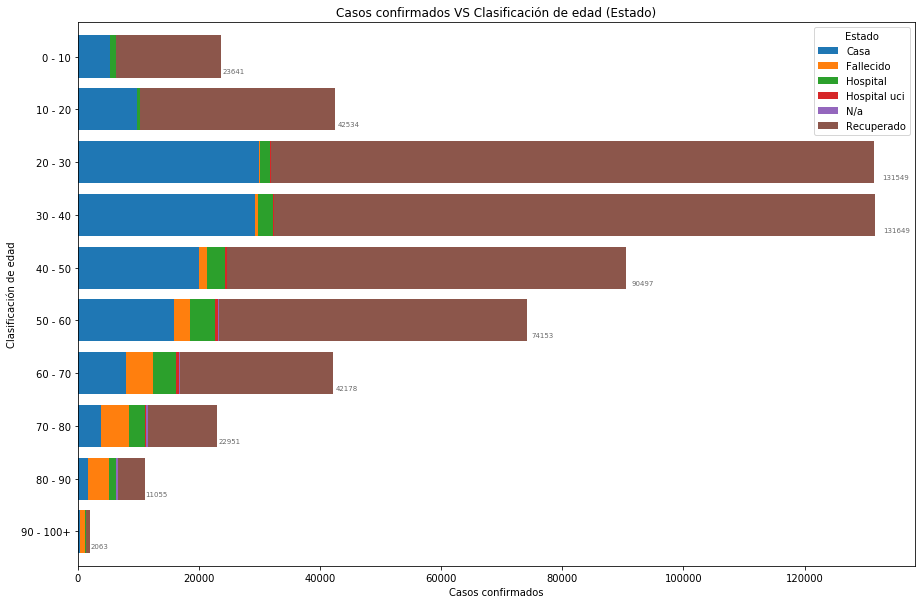

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5345         30       870            46   28   
10 - 20                 9710         30       439            30   20   
20 - 30                29913        234      1642            77   51   
30 - 40                29220        597      2404           184   42   
40 - 50                20042       1332      2887           278   91   
50 - 60                15791       2745      4127           460  141   
60 - 70                 7981       4406      3815           437  237   
70 - 80                 3791       4624      2577           265  272   
80 - 90                 1657       3411      1228            69  231   
90 - 100+                315        775       187             7   58   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      17322  
10 - 20                     32305  
20 - 30                     99632  
30 - 40                     99202  
40 - 50                     65867  
50 - 60                     50889  
60 - 70                     25302  
70 - 80                     11422  
80 - 90                      4459  
90 - 100+                     721

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

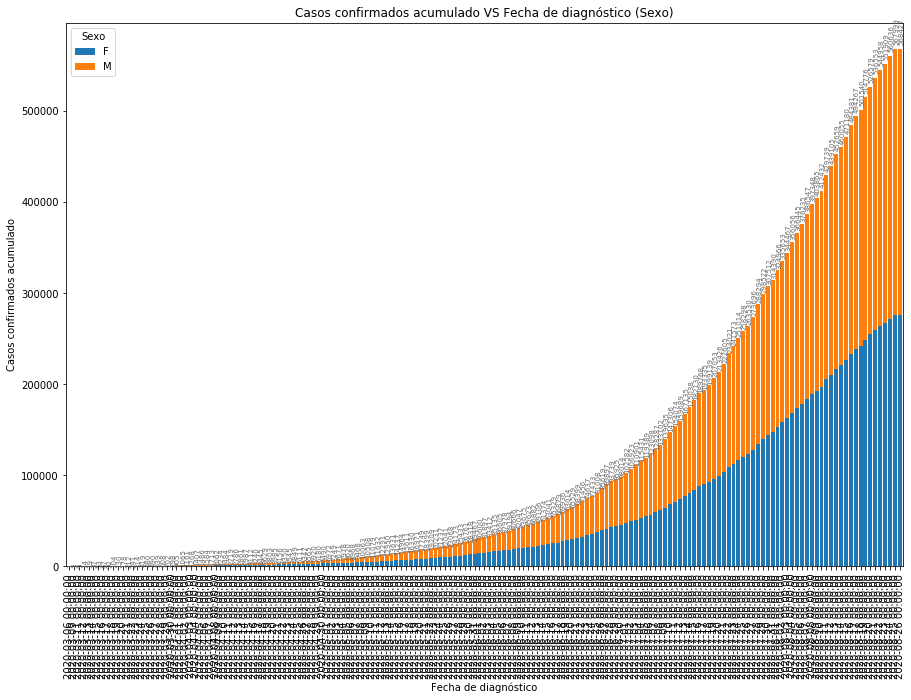

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-26            275637.0  292790.0
2020-08-25            275413.0  292586.0
2020-08-24            271724.0  288912.0
2020-08-23            267352.0  284557.0
2020-08-22            263806.0  281152.0
2020-08-21            259816.0  276737.0
2020-08-20            254769.0  271810.0
2020-08-19            248815.0  265961.0
2020-08-18            241930.0  259610.0
2020-08-17            238398.0  255869.0
2020-08-16            233173.0  251208.0
2020-08-15            226270.0  244910.0
2020-08-14            220586.0  239469.0
2020-08-13            216800.0  235859.0
2020-08-12            210010.0  229095.0
2020-08-11            205373.0  224366.0
2020-08-10            196399.0  216033.0
2020-08-09            192098.0  211767.0
2020-08-08            188737.0  208611.0
2020-08-07            183471.0  203076.0
2020-08-06            178434.0  197801.0
2020-08-05            173587.0  192858.0
2020-08-04            168382.0  187674.0
2020-08-03            162573.0  181894.0
2020-08-02            158306.0  177347.0
2020-08-01            152842.0  172124.0
2020-07-31            147723.0  166667.0
2020-07-30            144274.0  163238.0
2020-07-29            139903.0  158619.0
2020-07-28            134827.0  153467.0
2020-07-27            127716.0  145980.0
2020-07-26            122845.0  140685.0
2020-07-25            120446.0  137852.0
2020-07-24            116759.0  134255.0
2020-07-23            112394.0  129179.0
2020-07-22            108825.0  125196.0
2020-07-21            103662.0  118943.0
2020-07-20             99360.0  114066.0
2020-07-19             96384.0  110669.0
2020-07-18             92594.0  106545.0
2020-07-17             89813.0  103522.0
2020-07-16             88056.0  101712.0
2020-07-15             84307.0   97823.0
2020-07-14             80938.0   94100.0
2020-07-13             77342.0   89793.0
2020-07-12             73773.0   85916.0
2020-07-11             71099.0   82975.0
2020-07-10             67885.0   79421.0
2020-07-09             64381.0   75254.0
2020-07-08             61416.0   71686.0
2020-07-07             59106.0   69181.0
2020-07-06             56697.0   66401.0
2020-07-05             54944.0   64445.0
2020-07-04             53110.0   62321.0
2020-07-03             51081.0   59820.0
2020-07-02             49225.0   57698.0
2020-07-01             47196.0   55386.0
2020-06-30             45121.0   52893.0
2020-06-29             44148.0   51777.0
2020-06-28             43148.0   50591.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

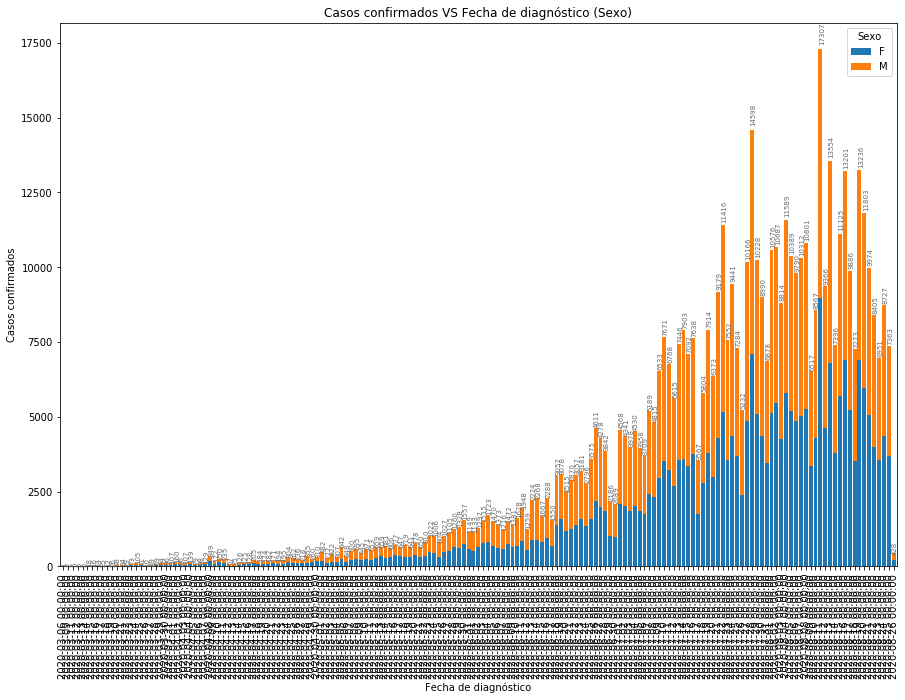

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-26             224.0   204.0
2020-08-25            3689.0  3674.0
2020-08-24            4372.0  4355.0
2020-08-23            3546.0  3405.0
2020-08-22            3990.0  4415.0
2020-08-21            5047.0  4927.0
2020-08-20            5954.0  5849.0
2020-08-19            6885.0  6351.0
2020-08-18            3532.0  3741.0
2020-08-17            5225.0  4661.0
2020-08-16            6903.0  6298.0
2020-08-15            5684.0  5441.0
2020-08-14            3786.0  3610.0
2020-08-13            6790.0  6764.0
2020-08-12            4637.0  4729.0
2020-08-11            8974.0  8333.0
2020-08-10            4301.0  4266.0
2020-08-09            3361.0  3156.0
2020-08-08            5266.0  5535.0
2020-08-07            5037.0  5275.0
2020-08-06            4847.0  4943.0
2020-08-05            5205.0  5184.0
2020-08-04            5809.0  5780.0
2020-08-03            4267.0  4547.0
2020-08-02            5464.0  5223.0
2020-08-01            5119.0  5457.0
2020-07-31            3449.0  3429.0
2020-07-30            4371.0  4619.0
2020-07-29            5076.0  5152.0
2020-07-28            7111.0  7487.0
2020-07-27            4871.0  5295.0
2020-07-26            2399.0  2833.0
2020-07-25            3687.0  3597.0
2020-07-24            4365.0  5076.0
2020-07-23            3569.0  3983.0
2020-07-22            5163.0  6253.0
2020-07-21            4302.0  4877.0
2020-07-20            2976.0  3397.0
2020-07-19            3790.0  4124.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3749.0  3889.0
2020-07-15            3369.0  3723.0
2020-07-14            3596.0  4307.0
2020-07-13            3569.0  3877.0
2020-07-12            2674.0  2941.0
2020-07-11            3214.0  3554.0
2020-07-10            3504.0  4167.0
2020-07-09            2965.0  3568.0
2020-07-08            2310.0  2505.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2501.0
2020-07-03            1856.0  2122.0
2020-07-02            2029.0  2312.0
2020-07-01            2075.0  2493.0
2020-06-30             973.0  1116.0
2020-06-29            1000.0  1186.0
2020-06-28            1840.0  2002.0

### - Casos confirmados VS Clasificación de edad (Sexo)

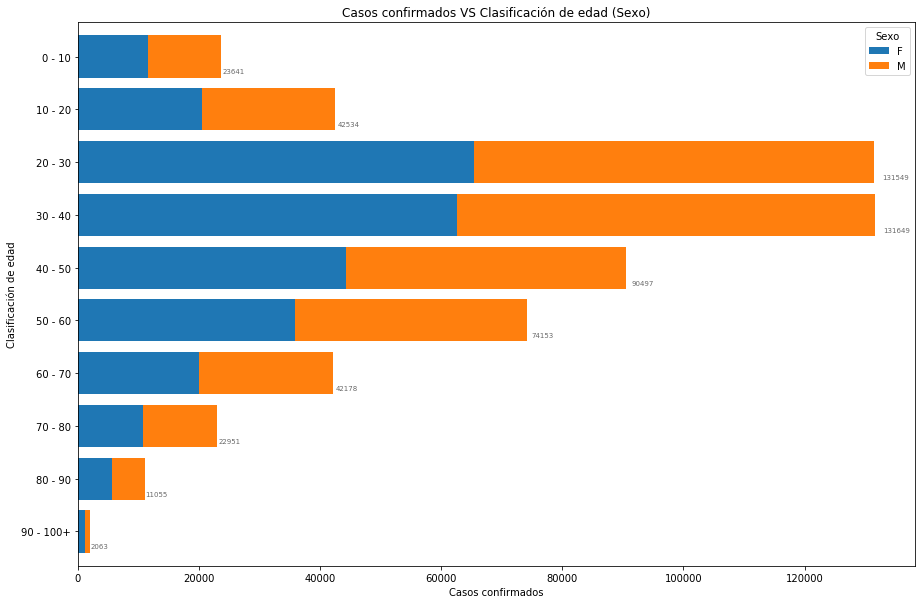

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 11554  12087
10 - 20                20406  22128
20 - 30                65354  66195
30 - 40                62625  69024
40 - 50                44191  46306
50 - 60                35828  38325
60 - 70                19979  22199
70 - 80                10718  12233
80 - 90                 5624   5431
90 - 100+               1176    887

### - Casos confirmados VS Estado (Sexo)

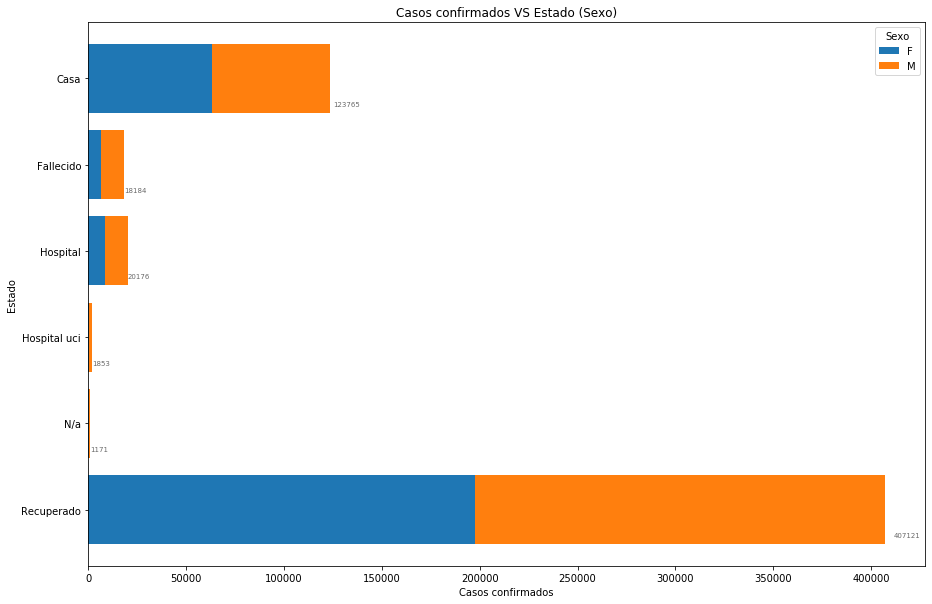

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           63409   60356
Fallecido       6516   11668
Hospital        8621   11555
Hospital uci     648    1205
N/a              503     668
Recuperado    197758  209363

### - Casos confirmados VS Tipo de contagio (Sexo)

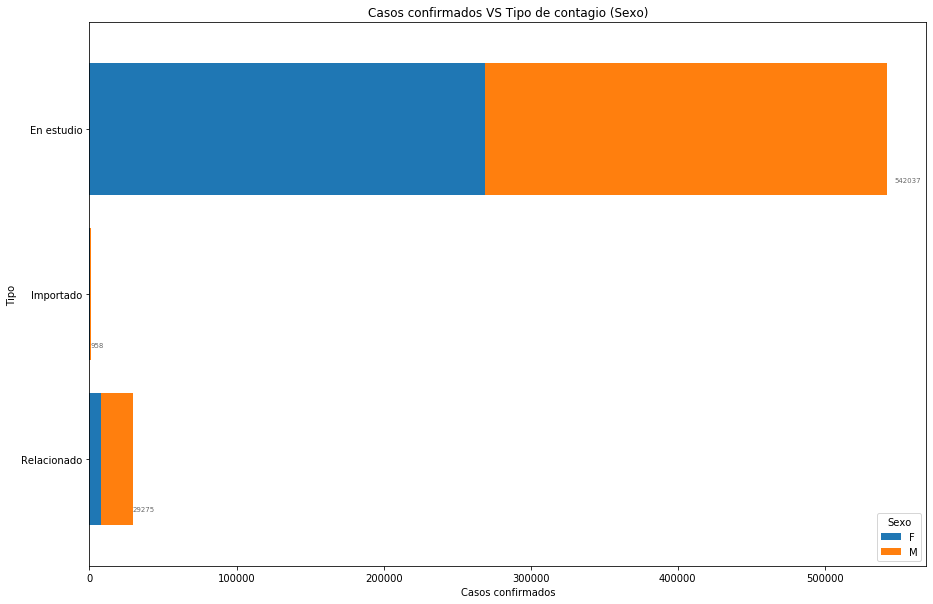

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   269013  273024
Importado       450     508
Relacionado    7992   21283

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

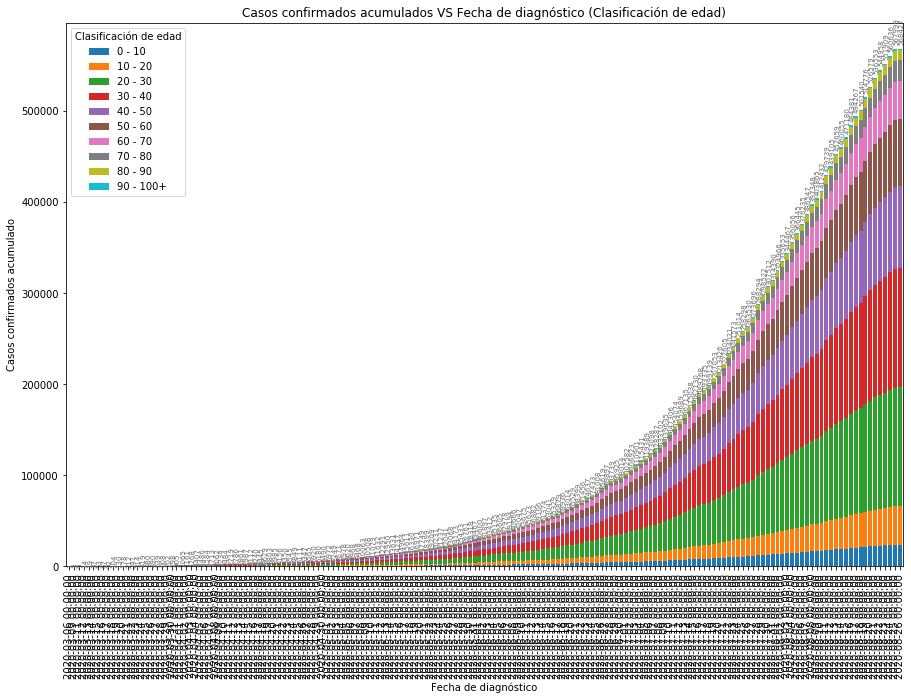

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-26              23506    42258   130638   130722    89932    73682   
2020-08-25              23494    42213   130554   130627    89877    73621   
2020-08-24              23219    41750   128853   128897    88677    72662   
2020-08-23              22883    41107   126828   126948    87330    71520   
2020-08-22              22594    40548   125165   125319    86310    70600   
2020-08-21              22284    39906   123244   123327    85050    69534   
2020-08-20              21874    39181   120872   121067    83478    68227   
2020-08-19              21402    38346   118282   118428    81615    66641   
2020-08-18              20781    37375   115303   115461    79454    64969   
2020-08-17              20532    36881   113704   113822    78296    63968   
2020-08-16              20021    36131   111508   111744    76720    62647   
2020-08-15              19409    35000   108572   108869    74619    60913   
2020-08-14              18912    34171   106030   106406    72873    59415   
2020-08-13              18661    33643   104337   104764    71681    58375   
2020-08-12              18044    32587   101280   101697    69520    56585   
2020-08-11              17705    31960    99228    99544    68033    55337   
2020-08-10              16917    30721    95149    95535    65216    53104   
2020-08-09              16590    30047    93215    93548    63874    51996   
2020-08-08              16349    29626    91716    92128    62794    51117   
2020-08-07              15934    28843    89280    89491    61095    49702   
2020-08-06              15520    28074    86921    87058    59457    48367   
2020-08-05              15072    27331    84744    84823    57889    47094   
2020-08-04              14646    26608    82361    82417    56204    45730   
2020-08-03              14157    25790    79705    79708    54302    44147   
2020-08-02              13833    25181    77708    77658    52957    42931   
2020-08-01              13391    24461    75299    75267    51152    41430   
2020-07-31              12978    23606    72746    72759    49532    40087   
2020-07-30              12705    23149    71216    71122    48357    39239   
2020-07-29              12361    22436    69034    68990    47031    38065   
2020-07-28              11979    21690    66613    66516    45346    36820   
2020-07-27              11350    20554    63288    63228    43029    34887   
2020-07-26              10964    19832    60903    60846    41361    33675   
2020-07-25              10753    19507    59715    59619    40548    32994   
2020-07-24              10469    19023    58079    57915    39381    32004   
2020-07-23              10148    18302    55874    55626    37905    30770   
2020-07-22               9871    17786    54191    53878    36704    29780   
2020-07-21               9465    16940    51469    51288    34919    28236   
2020-07-20               9105    16313    49305    49107    33437    27085   
2020-07-19               8827    15853    47950    47647    32369    26256   
2020-07-18               8514    15193    46116    45791    31058    25274   
2020-07-17               8292    14851    44822    44375    30101    24522   
2020-07-16               8169    14632    44020    43514    29554    24068   
2020-07-15               7827    14121    42307    41702    28301    23046   
2020-07-14               7532    13585    40699    40088    27170    22112   
2020-07-13               7236    13003    38831    38210    25894    21136   
2020-07-12               6981    12514    37049    36495    24680    20148   
2020-07-11               6740    12089    35738    35222    23766    19406   
2020-07-10               6489    11641    34107    33591    22681    18550   
2020-07-09               6204    11091    32252    31708    21523    17562   
2020-07-08            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

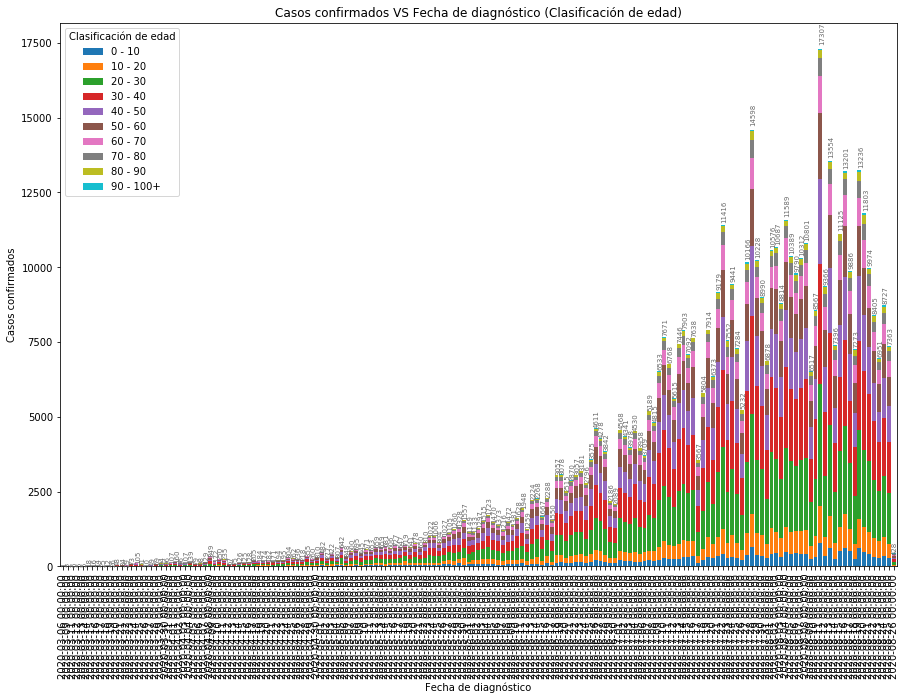

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-26                 12       45       84       95       55       61   
2020-08-25                275      463     1701     1730     1200      959   
2020-08-24                336      643     2025     1949     1347     1142   
2020-08-23                289      559     1663     1629     1020      920   
2020-08-22                310      642     1921     1992     1260     1066   
2020-08-21                410      725     2372     2260     1572     1307   
2020-08-20                472      835     2590     2639     1863     1586   
2020-08-19                621      971     2979     2967     2161     1672   
2020-08-18                249      494     1599     1639     1158     1001   
2020-08-17                511      750     2196     2078     1576     1321   
2020-08-16                612     1131     2936     2875     2101     1734   
2020-08-15                497      829     2542     2463     1746     1498   
2020-08-14                251      528     1693     1642     1192     1040   
2020-08-13                617     1056     3057     3067     2161     1790   
2020-08-12                339      627     2052     2153     1487     1248   
2020-08-11                788     1239     4079     4009     2817     2233   
2020-08-10                327      674     1934     1987     1342     1108   
2020-08-09                241      421     1499     1420     1080      879   
2020-08-08                415      783     2436     2637     1699     1415   
2020-08-07                414      769     2359     2433     1638     1335   
2020-08-06                448      743     2177     2235     1568     1273   
2020-08-05                426      723     2383     2406     1685     1364   
2020-08-04                489      818     2656     2709     1902     1583   
2020-08-03                324      609     1997     2050     1345     1216   
2020-08-02                442      720     2409     2391     1805     1501   
2020-08-01                413      855     2553     2508     1620     1343   
2020-07-31                273      457     1530     1637     1175      848   
2020-07-30                344      713     2182     2132     1326     1174   
2020-07-29                382      746     2421     2474     1685     1245   
2020-07-28                629     1136     3325     3288     2317     1933   
2020-07-27                386      722     2385     2382     1668     1212   
2020-07-26                211      325     1188     1227      813      681   
2020-07-25                284      484     1636     1704     1167      990   
2020-07-24                321      721     2205     2289     1476     1234   
2020-07-23                277      516     1683     1748     1201      990   
2020-07-22                406      846     2722     2590     1785     1544   
2020-07-21                360      627     2164     2181     1482     1151   
2020-07-20                278      460     1355     1460     1068      829   
2020-07-19                313      660     1834     1856     1311      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      511     1713     1812     1253     1022   
2020-07-15                295      536     1608     1614     1131      934   
2020-07-14                296      582     1868     1878     1276      976   
2020-07-13                255      489     1782     1715     1214      988   
2020-07-12                241      425     1311     1273      914      742   
2020-07-11                251      448     1631     1631     1085      856   
2020-07-10                285      550     1855     1883     1158      988   
2020-07-09                220      428     1554     1570     1040      813   
2020-07-08            

### - Casos confirmados VS Estado (Clasificación de edad)

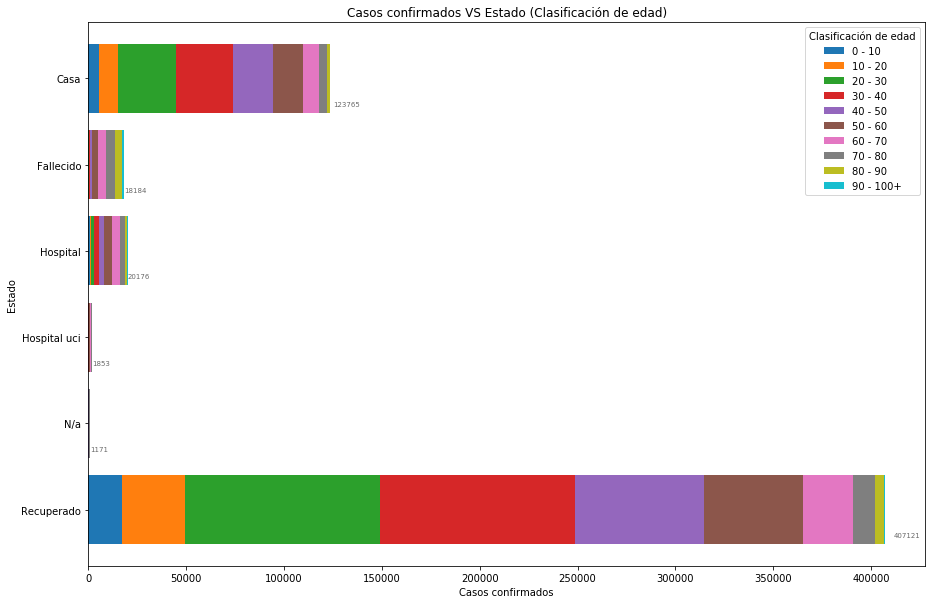

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5345     9710    29913    29220    20042    15791   
Fallecido                  30       30      234      597     1332     2745   
Hospital                  870      439     1642     2404     2887     4127   
Hospital uci               46       30       77      184      278      460   
N/a                        28       20       51       42       91      141   
Recuperado              17322    32305    99632    99202    65867    50889   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7981     3791     1657        315  
Fallecido                 4406     4624     3411        775  
Hospital                  3815     2577     1228        187  
Hospital uci               437      265       69          7  
N/a                        237      272      231         58  
Recuperado               25302    11422     4459        721

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

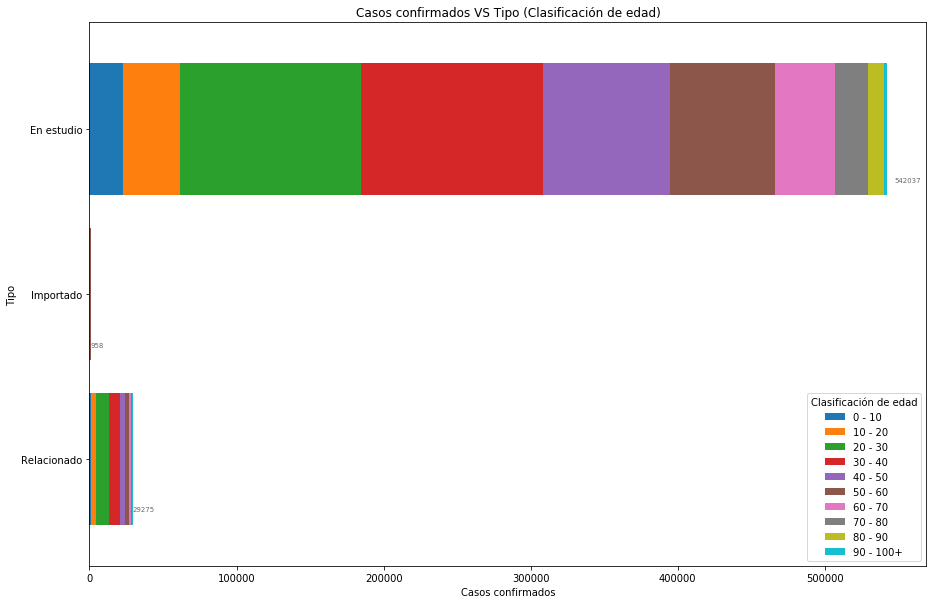

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              22651    38777   123001   123833    86592    71460   
Importado                   5       37      240      222      169      144   
Relacionado               985     3720     8308     7594     3736     2549   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               40767    22322    10666       1968  
Importado                   95       36        9          1  
Relacionado               1316      593      380         94

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>